# Introduction

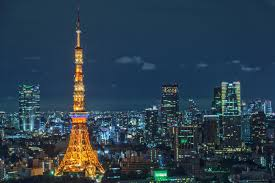

## JAPAN
Have you noticed that there are more and more names of kernels and teams with characters which do not look like English or Chinese?
Or do you see more and more profile icons with a 2D girl? English discussions always missing "the" or "a"? 

They may be ... Japanese.

What is Japan famous for? 

- Sushi
- Ramen
- Anime
- Manga

Sure, but how about data science?

On December 11-12, 2019 we will have the **kaggle days in Tokyo**, JAPAN. This is upcoming, so maybe it is worthwhile looking into what kagglers in Japan have to say. The result of this analysis might be useful to find something to chat with locals in the event!

# Results

In [ ]:
# importing libraries
import numpy as np 
import pandas as pd 
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
from ipywidgets import interact, interactive, interact_manual
import ipywidgets as widgets
import colorlover as cl

### Load data
Many of the code are shamelessly taken from https://www.kaggle.com/artgor/a-look-at-russian-kagglers-over-time. Thanks a lot and pls upvote the kernel!

In [ ]:
# loading data from different years
DIR = '/kaggle/input/kaggle-survey-2018/'
df_free_18 = pd.read_csv(DIR + 'freeFormResponses.csv', low_memory=False, header=[0,1])
df_choice_18 = pd.read_csv(DIR + 'multipleChoiceResponses.csv', low_memory=False, header=[0,1])
# Format Dataframes
df_free_18.columns = ['_'.join(col) for col in df_free_18.columns]
df_choice_18.columns = ['_'.join(col) for col in df_choice_18.columns]

DIR = '/kaggle/input/kaggle-survey-2017/'
df_free_17 = pd.read_csv(DIR + 'freeformResponses.csv', low_memory=False)
df_choice_17 = pd.read_csv(DIR + 'multipleChoiceResponses.csv', low_memory=False, encoding='latin-1')

DIR = '/kaggle/input/kaggle-survey-2019/'
df_free_19 = pd.read_csv(DIR + 'other_text_responses.csv', low_memory=False)
df_choice_19 = pd.read_csv(DIR + 'multiple_choice_responses.csv', low_memory=False, encoding='latin-1', header=[0,1])
df_choice_19.columns = ['_'.join(col) for col in df_choice_19.columns]

### Questions
FYI, here is the list of questions.

In [ ]:
df_choice_19.columns.values.tolist()

### Preprocess

In [ ]:
# processing data for visualizations
top_count = df_choice_19['Q3_In which country do you currently reside?'].value_counts().head(8).reset_index().rename(
    columns={'Q3_In which country do you currently reside?': 'count', 'index': 'Country'})

# taking only responders from your country of interest
def preprocess_by_country(df_choice_17, df_choice_18, df_choice_19, country="Japan"):
    df_choice_17 = df_choice_17.loc[df_choice_17['Country'] == country]
    df_choice_18 = df_choice_18.loc[df_choice_18['Q3_In which country do you currently reside?'] == country]
    df_choice_19 = df_choice_19.loc[df_choice_19['Q3_In which country do you currently reside?'] == country]

    def get_age(x: int):
        """
        Convert numerical age to categories.
        """
        if 18 <= x <= 21:
            return '18-21'
        elif 22 <= x <= 24:
            return '22-24'
        elif 25 <= x <= 29:
            return '25-29'
        elif 30 <= x <= 34:
            return '30-34'
        elif 35 <= x <= 39:
            return '35-39'
        elif 40 <= x <= 44:
            return '40-44'
        elif 45 <= x <= 49:
            return '45-49'
        elif 50 <= x <= 54:
            return '50-54'
        elif 55 <= x <= 59:
            return '55-59'
        elif 60 <= x <= 69:
            return '60-69'
        elif x >= 70:
            return '70+'

    # create a new age column with the same name and unique values in all datasets
    df_choice_17['Age_'] = df_choice_17['Age'].apply(lambda x: get_age(x))
    df_choice_18['Age_'] = df_choice_18['Q2_What is your age (# years)?']
    df_choice_18.loc[df_choice_18['Age_'].isin(['70-79', '80+']), 'Age_'] = '70+'
    df_choice_19['Age_'] = df_choice_19['Q1_What is your age (# years)?']

    # renaming columns so that it would be easier to work with them
    df_choice_17 = df_choice_17.rename(columns={'GenderSelect': 'Gender', 'FormalEducation': 'Degree'})
    df_choice_18 = df_choice_18.rename(columns={'Q1_What is your gender? - Selected Choice': 'Gender', 'Q9_What is your current yearly compensation (approximate $USD)?': 'Salary',
                                                'Q4_What is the highest level of formal education that you have attained or plan to attain within the next 2 years?': 'Degree'})
    df_choice_19 = df_choice_19.rename(columns={'Q2_What is your gender? - Selected Choice': 'Gender', 'Q10_What is your current yearly compensation (approximate $USD)?': 'Salary',
                                                'Q4_What is the highest level of formal education that you have attained or plan to attain within the next 2 years?': 'Degree'})
    df_choice_19['Degree'] = df_choice_19['Degree'].replace({'Masterâs degree': 'Master’s degree', 'Bachelorâs degree': 'Bachelor’s degree',
                                                             'Some college/university study without earning a bachelorâs degree': 'Some college/university study without earning a bachelor’s degree'})
    df_choice_17['Degree'] = df_choice_17['Degree'].replace({"Master's degree": 'Master’s degree', "Bachelor's degree": 'Bachelor’s degree',
                                                             "Some college/university study without earning a bachelor's degree": 'Some college/university study without earning a bachelor’s degree'})

    # changing salary values to the same categories
    df_choice_19.loc[df_choice_19['Salary'].isin(['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499', '7,500-9,999']), 'Salary'] = '0-10,000'
    df_choice_19.loc[df_choice_19['Salary'].isin(['10,000-14,999', '15,000-19,999']), 'Salary'] = '10-20,000'
    df_choice_19.loc[df_choice_19['Salary'].isin(['20,000-24,999', '25,000-29,999']), 'Salary'] = '20-30,000'
    df_choice_19.loc[df_choice_19['Salary'] == '30,000-39,999', 'Salary'] = '30-40,000'
    df_choice_19.loc[df_choice_19['Salary'] == '40,000-49,999', 'Salary'] = '40-50,000'
    df_choice_19.loc[df_choice_19['Salary'] == '50,000-59,999', 'Salary'] = '50-60,000'
    df_choice_19.loc[df_choice_19['Salary'] == '60,000-69,999', 'Salary'] = '60-70,000'
    df_choice_19.loc[df_choice_19['Salary'] == '70,000-79,999', 'Salary'] = '70-80,000'
    df_choice_19.loc[df_choice_19['Salary'] == '80,000-89,999', 'Salary'] = '80-90,000'
    df_choice_19.loc[df_choice_19['Salary'] == '90,000-99,999', 'Salary'] = '90-100,000'
    df_choice_19.loc[df_choice_19['Salary'] == '100,000-124,999', 'Salary'] = '100-125,000'
    df_choice_19.loc[df_choice_19['Salary'] == '125,000-149,999', 'Salary'] = '125-150,000'
    df_choice_19.loc[df_choice_19['Salary'] == '150,000-199,999', 'Salary'] = '150-200,000'
    df_choice_19.loc[df_choice_19['Salary'] == '200,000-249,999', 'Salary'] = '200-250,000'
    df_choice_19.loc[df_choice_19['Salary'] == '250,000-299,999', 'Salary'] = '250-300,000'
    df_choice_19.loc[df_choice_19['Salary'] == '300,000-500,000', 'Salary'] = '300-500,000'
    df_choice_19.loc[df_choice_19['Salary'] == '> $500,000', 'Salary'] = '500,000+'
    df_choice_18.loc[df_choice_18['Salary'].isin(['400-500,000', '300-400,000']), 'Salary'] = '300-500,000'
    
    return df_choice_17, df_choice_18, df_choice_19

In [ ]:
# Functions

# some of the code is taken from my old kernel: https://www.kaggle.com/artgor/russia-usa-india-and-other-countries

def plot_gender_vars(df_choice_17, df_choice_18, df_choice_19, var1: str = '', title_name: str = '', nationality="Japanese"):
    """
    Make separate count plots for genders over years.
    """
    colors = cl.scales['3']['qual']['Paired']
    names = {0: '2017', 1: '2018', 2: '2019'}
    fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Male', 'Female'), print_grid=False)
    # there are too little responders, who don't identify as Male/Female, I have decided that I can use the most common genders.
    for j, c in enumerate(['Male', 'Female']):
        data = []
        for i, df in enumerate([df_choice_17, df_choice_18, df_choice_19]):
            grouped = df.loc[(df['Gender'] == c), var1].value_counts().sort_index().reset_index()
            grouped['Age_'] = grouped['Age_'] / np.sum(grouped['Age_'])
            trace = go.Bar(
                x=grouped['index'],
                y=grouped.Age_,
                name=names[i],
                marker=dict(color=colors[i]),
                showlegend=True if j == 0 else False,
                legendgroup=i
            )
            fig.append_trace(trace, 1, j + 1)    

    fig['layout'].update(height=400, width=1000, title=f'Rate of {nationality} kagglers by {title_name} and gender');
    return fig


def plot_var(df_choice_17, df_choice_18, df_choice_19, var1: str = '', title_name: str = '', nationality="Japanese"):
    """
    Plot one variable over years.
    """
    colors = cl.scales['3']['qual']['Paired']
    names = {0: '2017', 1: '2018', 2: '2019'}
    
    data = []
    for i, df in enumerate([df_choice_17, df_choice_18, df_choice_19]):
        grouped = df[var1].value_counts().sort_index().reset_index()
        grouped[var1] = grouped[var1] / np.sum(grouped[var1])
        trace = go.Bar(
            x=grouped['index'],
            y=grouped[var1],
            name=names[i],
            marker=dict(color=colors[i]),
            legendgroup=i
        )
        data.append(trace)
    layout = dict(height=400, width=1000, title=f'{nationality} kagglers by {title_name}');  
    fig = dict(data=data, layout=layout)
    return fig
    
def plot_var_salary(df_choice_18, df_choice_19, var1: str = '', title_name: str = '', normalize: bool = False, nationality="Japanese"):
    """
    Plot salary over years. This is a separate function, because
    it is necessary to add code for sorting.
    """
    colors = cl.scales['3']['qual']['Paired']
    names = {0: '2018', 1: '2019'}
    
    data = []
    for i, df in enumerate([df_choice_18, df_choice_19]):
        grouped = df[var1].value_counts().sort_index().reset_index()
        if normalize:
            grouped[var1] = grouped[var1] / np.sum(grouped[var1])
        map_dict = {'0-10,000': 0,
                    '10-20,000': 1,
                    '100-125,000': 10,
                    '125-150,000' : 11,
                    '150-200,000': 12,
                    '20-30,000': 2,
                    '200-250,000': 13,
                    '250-300,000': 14,
                    '30-40,000': 3,
                    '300-500,000': 15,
                    '40-50,000': 4,
                    '50-60,000': 5,
                    '60-70,000': 6,
                    '70-80,000': 7,
                    '80-90,000': 8,
                    '90-100,000': 9,
                    '500,000+': 16,
                    'I do not wish to disclose my approximate yearly compensation': 17}
        grouped['sorting'] = grouped['index'].apply(lambda x: map_dict[x])
        grouped = grouped.loc[grouped['index'] != 'I do not wish to disclose my approximate yearly compensation']
        grouped = grouped.sort_values('sorting', ascending=True)
        trace = go.Bar(
            x=grouped['index'],
            y=grouped[var1],
            name=names[i],
            marker=dict(color=colors[i]),
            legendgroup=i
        )
        data.append(trace)
    layout = dict(height=500, width=1000, title=f'{nationality} kagglers by {title_name}');  
    fig = dict(data=data, layout=layout)
    return fig


def plot_choice_var(df_choice_19, var: str = '', title_name: str = ''):
    """
    Plot a variable, in which responders could select several answers.
    """
    col_names = [col for col in df_choice_19.columns if f'{var}_Part' in col]
    data = []
    small_df = df_choice_19[col_names]
    text_values = [col.split('- ')[2] for col in col_names]
    counts = []
    for m, n in zip(col_names, text_values):
        if small_df[m].nunique() == 0:
            counts.append(0)
        else:
            counts.append(sum(small_df[m] == n))
            
    trace = go.Bar(
        x=text_values,
        y=counts,
        name='c',
        marker=dict(color='silver'),
        showlegend=False
    )
    data.append(trace)    
    fig = go.Figure(data=data)
    fig['layout'].update(height=600, width=1000, title=f'Popular {title_name}');
    return fig

## How many respondants were there in Japan?
Here is the ranking. You can see that the majority is Indian, yet Japan came into the 5th place (673 respondants). So seemingly there are relatively many kagglers in Japan.

In [ ]:
top_count = top_count.sort_values('count')
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Bar(y=top_count['Country'], x=top_count['count'], orientation='h', 
                     name='Number of respondents by country in 2019'), row=1, col=1)
fig['layout'].update(height=600, width=600, title=f'The number of respondants in 2019');
iplot(fig);

### The number of respondants as a function of year
Interestingly, although the number itself is very different, Japan exhibits the same pattern as India: monotonic increase by year. This is exciting for Japan, having more and more kagglers.

In [ ]:
countries_to_analyze = ("India", "United States of America", "Brazil", "Japan", "Russia", "China")
d2017 = {}
d2018 = {}
d2019 = {}
for c in countries_to_analyze:
    df17, df18, df19 = preprocess_by_country(df_choice_17, df_choice_18, df_choice_19, country=c)
    d2017[c] = df17
    d2018[c] = df18
    d2019[c] = df19

In [ ]:
fig = tools.make_subplots(rows=2, cols=3, subplot_titles=countries_to_analyze, print_grid=False)
for i, c in enumerate(countries_to_analyze):
    df_count = pd.DataFrame({'Year': [2017, 2018, 2019], 'Count': [d2017[c].shape[0], d2018[c].shape[0], d2019[c].shape[0]]})
    if i < 3:
        row = 1
        col = i + 1
    else:        
        row = 2
        col = i - 2
    fig.append_trace(go.Bar(x=df_count['Year'], y=df_count['Count'], name=c, showlegend=False), row=row, col=col)

fig['layout'].update(height=800, width=1000);
iplot(fig);

### Age and gender
They are relatively young. It's kind of cool to see 70+ kagglers.  

In [ ]:
fig = plot_gender_vars(d2017["Japan"], d2018["Japan"], d2019["Japan"], var1='Age_', title_name='age')
iplot(fig);

### Degree
Mostly master, as is the case with many other countries. Not many people dare to go to get PhD.

In [ ]:
fig = plot_var(d2017["Japan"], d2018["Japan"], d2019["Japan"], var1='Degree', title_name='degree')
iplot(fig);

### Salary
Well there are more poor people (whose income is less than 10,000) in 2019 than 2018;( On the other hand, there are more people with > 100K...
It seems that except for the lowest bin, kagglers in Japan earn more than the previous year. Indeed, as I am living in Japan, I have encountered many job posts which favour kagglers.

[This job post by a company called "Rist" located in Kyoto](https://recruit.jobcan.jp/rist/show/b001/115250) is for example an iconic one. This offer is limited to kaggle masters (!) and the yearly compensation is around 100k or more.

Also, [DeNA](https://dena.ai/kaggle/) is a quite famous domestic IT company which is well known to love kagglers and offer competitive compensations. 

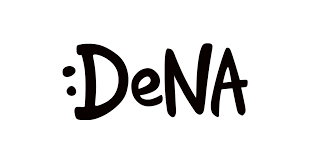

There seems to be a trend that **more and more attractive offers are waiting for Kagglers in Japan**. This could explain the reason why the sharp increase in the lowest bin...more and more youngsters are seemingly joining Kaggle to get better an offer.  

In [ ]:
fig = plot_var_salary(d2018["Japan"], d2019["Japan"], var1='Salary', title_name='salary')
iplot(fig);

### Job titles
Software engineers and data scientists are 2 tops. Students follow, and they will be likely to be one or both of them in the near future.

In [ ]:
d2019["Japan"]['Q5_Select the title most similar to your current role (or most recent title if retired): - Selected Choice'].value_counts().plot.bar()

### Resources
Except for Kaggle, twitter and blogs are quite popular. Indeed, there are some influencers being Kaggle GM or master...so they may stimulate followers to keep up. 

In [ ]:
fig = plot_choice_var(d2019["Japan"], var='Q12', title_name='resources')
iplot(fig);

### Popular languages
Python and that's it!

In [ ]:
fig = plot_choice_var(d2019["Japan"], var='Q18', title_name='languages')
iplot(fig);

# Conclusion
The future of kagglers in Japan seems bright.

- More and more people joining Kaggle
- Among them the top 3 occupations are software engineers, data scientists, and students
- The yearly compensation for kagglers seems to get higher
- They actively communicate mainly via blogs and twitters and learn and motivate one another

So...are you ready for Kaggle days in Tokyo?